In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

if os.getcwd()[-7:] == 'AAM_Sim':
    print(os.getcwd())
else:
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    print(os.getcwd())
    
from Engine.GlobalClock import GlobalClock, Agent
from Engine.State import State
from Engine.Aircraft import AircraftType
from Engine.FlightPlan import FlightPlan
from Engine.MultiRotorController import MultiRotorController
from Engine.Wind import WindField
from Engine.Sensors import NavUpdate, GPSPosNavUpdate, NACv
from Engine.DragModel import DragModel
from Engine.TrackingSystem import *
from Engine.ConflictDetector import ConflictDetector

from CrossPlatformDev import my_print, join_str

import time

C:\Users\quekz\PycharmProjects\AAM_Sim


In [2]:
def FP_gen(HDG, speed, time, num_wpts, ini_pos):
    """Function that generates a flight plan according to encounter design. 
    A/C have fixed heading and will fly toward WPTs. 
    HDG --> desired A/C HDG (counter-clockwise from x-axis in RADIANS)
    speed --> desired A/C cruise spd
    time --> approximate duration for each flight leg (between 2 consecutive wpts)
    num_wpts --> number of wpts along the flight path
    ini_pos --> initial position of the A/C
    """
    wpt_list = []
    wpt_times = []
    spds = []
    mode_list = []
    duration_list = []
    for i in range(num_wpts):
        wpt_list.append(ini_pos + i*speed*time*np.array([np.cos(HDG), np.sin(HDG), 0]))
        wpt_times.append(i*time*1.1) # Give a 10% margin to each leg duration
        if i > 0:
            spds.append(speed)
            mode_list.append('Direct_P2P')
            duration_list.append(time*1.1) # Give a 10% margin to each leg duration
    wpt_start_list = wpt_list[0:num_wpts-1]
    wpt_end_list = wpt_list[1:]
    wpt_start_time = wpt_times[0:num_wpts-1]
    wpt_end_time = wpt_times[1:]
    return (FlightPlan(spds, mode_list,
                       wpt_start_list, wpt_start_time,
                       wpt_end_list, wpt_end_time, duration_list), wpt_list)


def calc_diameter(mass):
    """Data for this function obtained from log-log plot of popular DJI quadrotors"""
    if isinstance(mass, type(np.array([]))):
        diameter = (np.random.uniform(0.8, 1.2, size=len(mass)) * np.exp((0.3878 * np.log(mass) + 2.1387))).round(1)
    else:
        diameter = round(np.random.uniform(0.8, 1.2) * np.exp((0.3878 * np.log(mass) + 2.1387)), 1)
    return diameter


def estimate_max_linear_dim(prop_diam):
    """Estimates max linear dimension (m) based on prop diameter (inches). Based on commercially available DJI
    drone dimensions. """
    return 0.018*prop_diam + 0.2884

In [3]:
# File to be used for generating initial params

# Number of runs
num_runs = 10

# Global Params

GlobalPhysicsUpdateRate = 240 
GlobalSimStopTime = 200 
Cruise_Leg_Time = 15 
Num_Legs = 5 

WindUpdateRate = 1 
Wind_auto_x = 0.9 
Wind_auto_y = 0.9 
Wind_auto_z = 0
Wind_std_x = 3 
Wind_std_y = 3
Wind_std_z = 0 
Wind_mean_x = 0 
Wind_mean_y = 0 
Wind_mean_z = 0

# Some shared AC Params for this simulation

# AC GPS Error Models
GPS_Pos_Error_Hor_Auto = 0.994
GPS_Pos_Error_Vert_Auto = 0.994
# GPS_Pos_Error_Hor_Std = 4.0854 # (radial)
GPS_Pos_Error_Hor_Std = 0 # (radial)
# GPS_Pos_Error_Hor_Std = (GPS_Pos_Error_Hor_Std)/np.sqrt(0.5*(4-np.pi)) # Check formula! 
# GPS_Pos_Error_Hor_Std = (GPS_Pos_Error_Hor_Std/2)/np.sqrt(0.5*(4-np.pi)) # Pls chk formula before running!
# GPS_Pos_Error_Vert_Std = 1.5306
GPS_Pos_Error_Vert_Std = 0

# AC Cruise Spds
spd = 5

# AC1 Params
AC1_Mass = 1.2
AC1_Prop_Diameter = calc_diameter(AC1_Mass)
AC1_HDG = 0 
AC1_HDG = AC1_HDG * np.pi/180
AC1_Cruise_Speed = spd
radii = np.random.uniform(150,250)
AC1_Ini_Pos_x = -radii * np.cos(AC1_HDG)
AC1_Ini_Pos_y = -radii * np.sin(AC1_HDG)
AC1_Ini_Pos_z =  0
AC1_Ini_Pos = np.array([AC1_Ini_Pos_x, AC1_Ini_Pos_y, AC1_Ini_Pos_z])

AC1_Ini_Vel_x = 0
AC1_Ini_Vel_y = 0
AC1_Ini_Vel_z = 0
AC1_Ini_Vel = np.array([AC1_Ini_Vel_x, AC1_Ini_Vel_y, AC1_Ini_Vel_z])

AC1_GPS_horizontal_std = GPS_Pos_Error_Hor_Std
AC1_GPS_horizontal_auto = GPS_Pos_Error_Hor_Auto
AC1_GPS_horizontal_auto = AC1_GPS_horizontal_auto 

AC1_GPS_vert_std = GPS_Pos_Error_Vert_Std
AC1_GPS_vert_auto = GPS_Pos_Error_Vert_Auto
AC1_GPS_vert_auto = AC1_GPS_vert_auto 

AC1_Ini_Pos_Err_x = np.random.normal(0, AC1_GPS_horizontal_std)
AC1_Ini_Pos_Err_y = np.random.normal(0, AC1_GPS_horizontal_std)
AC1_Ini_Pos_Err_z =  np.random.normal(0, AC1_GPS_vert_std)
AC1_Ini_Pos_Err = np.array([AC1_Ini_Pos_Err_x, AC1_Ini_Pos_Err_y, AC1_Ini_Pos_Err_z])

AC1_GPS_horizontal_std = AC1_GPS_horizontal_std
AC1_GPS_vert_std = AC1_GPS_vert_std 

AC1_Ini_Vel_Err_x = 0
AC1_Ini_Vel_Err_y = 0
AC1_Ini_Vel_Err_z = 0
AC1_Ini_Vel_Err = np.array([AC1_Ini_Vel_Err_x, AC1_Ini_Vel_Err_y, AC1_Ini_Vel_Err_z])

AC1_Ini_RPY_r = 0
AC1_Ini_RPY_p = 0
AC1_Ini_RPY_y = 0
AC1_Ini_RPY = np.array([AC1_Ini_RPY_r, AC1_Ini_RPY_p, AC1_Ini_RPY_y])

AC1_PhysicsUpdateRate = GlobalPhysicsUpdateRate # Already converted to array!
AC1_Controller_UpdateRate = 120 
AC1_Start_Time = 0

AC1_PosUpdateRate = 10
AC1_VelUpdateRate = 10
AC1_AccelUpdateRate = 120 
AC1_AirSpdSensorUpdateRate = 120

# Initialize AC1 Tracking System

AC1_TrackingUnit_UpdateRate = 1 
AC1_TrackingUnit_Pos_Quant = 0 
# AC1_TrackingUnit_Vel_Quant = 0
AC1_TrackingUnit_Vel_Quant = 'ASTM F3411-19'
AC1_TrackingUnit_Avail = 1 
# AC1_Latency = 0.5 
AC1_Latency = 0.1


# AC2 Params
AC2_Mass = 1.2 
AC2_Prop_Diameter = calc_diameter(AC2_Mass)
AC2_HDG = 90 
AC2_HDG = AC2_HDG * np.pi/180
AC2_Cruise_Speed = spd
radii = np.random.uniform(150,250)
AC2_Ini_Pos_x = -radii * np.cos(AC2_HDG)
AC2_Ini_Pos_y = -radii * np.sin(AC2_HDG)
AC2_Ini_Pos_z =  0
AC2_Ini_Pos = np.array([AC2_Ini_Pos_x, AC2_Ini_Pos_y, AC2_Ini_Pos_z])

AC2_Ini_Vel_x = 0
AC2_Ini_Vel_y = 0
AC2_Ini_Vel_z = 0
AC2_Ini_Vel = np.array([AC2_Ini_Vel_x, AC2_Ini_Vel_y, AC2_Ini_Vel_z])

AC2_GPS_horizontal_std = GPS_Pos_Error_Hor_Std
AC2_GPS_horizontal_auto = GPS_Pos_Error_Hor_Auto
AC2_GPS_horizontal_auto = AC2_GPS_horizontal_auto 

AC2_GPS_vert_std = GPS_Pos_Error_Vert_Std
AC2_GPS_vert_auto = GPS_Pos_Error_Vert_Auto
AC2_GPS_vert_auto = AC2_GPS_vert_auto 

AC2_Ini_Pos_Err_x = np.random.normal(0, AC2_GPS_horizontal_std)
AC2_Ini_Pos_Err_y = np.random.normal(0, AC2_GPS_horizontal_std)
AC2_Ini_Pos_Err_z =  np.random.normal(0, AC2_GPS_vert_std)
AC2_Ini_Pos_Err = np.array([AC2_Ini_Pos_Err_x, AC2_Ini_Pos_Err_y, AC2_Ini_Pos_Err_z])

AC2_GPS_horizontal_std = AC2_GPS_horizontal_std 
AC2_GPS_vert_std = AC2_GPS_vert_std 

AC2_Ini_Vel_Err_x = 0
AC2_Ini_Vel_Err_y = 0
AC2_Ini_Vel_Err_z = 0
AC2_Ini_Vel_Err = np.array([AC2_Ini_Vel_Err_x, AC2_Ini_Vel_Err_y, AC2_Ini_Vel_Err_z])

AC2_Ini_RPY_r = 0
AC2_Ini_RPY_p = 0
AC2_Ini_RPY_y = 0
AC2_Ini_RPY = np.array([AC2_Ini_RPY_r, AC2_Ini_RPY_p, AC2_Ini_RPY_y])

AC2_PhysicsUpdateRate = GlobalPhysicsUpdateRate # Already converted to array!
AC2_Controller_UpdateRate = 120
AC2_Start_Time = 0 

AC2_PosUpdateRate = 10 
AC2_VelUpdateRate = 10 
AC2_AccelUpdateRate = 120 
AC2_AirSpdSensorUpdateRate = 120 

# Initialize AC2 Tracking System

AC2_TrackingUnit_UpdateRate = 1
AC2_TrackingUnit_Pos_Quant = 0 
# AC2_TrackingUnit_Vel_Quant = 0
AC2_TrackingUnit_Vel_Quant = 'ED-282' 
AC2_TrackingUnit_Avail = 1 
# AC2_Latency = 0.5
AC2_Latency = 0.1

In [4]:
# Init All Agents/Classes

# Global Agents Init (Clock, Wind, etc.)

Wind = WindField(WindUpdateRate, 0, 
                 auto_x=Wind_auto_x, auto_y=Wind_auto_y, auto_z=Wind_auto_z,
                 std_x=Wind_std_x, std_y=Wind_std_y, std_z=Wind_std_z,
                 mean_x=Wind_mean_x, mean_y=Wind_mean_y, mean_z=Wind_mean_z)

clock = GlobalClock(update_rate=GlobalPhysicsUpdateRate, stop=GlobalSimStopTime, start=0)

# AC1 Flight Agents Init

AC1_AircraftType = AircraftType(mass=AC1_Mass, prop_diameter=AC1_Prop_Diameter, max_cruise_spd=20)
AC1_DragModel = DragModel(AC1_AircraftType, disabled=False)

AC1_State = State(AC1_PhysicsUpdateRate, AC1_Start_Time, 
                  AC1_Ini_Pos, AC1_Ini_Vel, 
                  AC1_Ini_Pos_Err, AC1_Ini_Vel_Err, 
                  Wind.get_windspd(AC1_Start_Time, AC1_Ini_Pos), AC1_AircraftType, 
                  rpy=AC1_Ini_RPY)

AC1_FlightPlan, AC1_WPTs = FP_gen(AC1_HDG, AC1_Cruise_Speed, Cruise_Leg_Time, Num_Legs+1, AC1_Ini_Pos)

AC1_Controller = MultiRotorController(AC1_Controller_UpdateRate, AC1_Start_Time, AC1_FlightPlan, AC1_AircraftType,
                                      wpt_tol_hor=0, wpt_tol_vert=0, wpt_tol=10)

AC1_Pos_Nav_Agent = GPSPosNavUpdate(AC1_PosUpdateRate, AC1_Start_Time, 
                                    AC1_GPS_horizontal_auto, AC1_GPS_horizontal_auto, AC1_GPS_vert_auto,
                                    AC1_GPS_horizontal_std, AC1_GPS_horizontal_std, AC1_GPS_vert_std,
                                    x_mean=0, y_mean=0, z_mean=0)
                                    # phase_delay=10 <-- manually set GPS phase delay during start-up (will rand if None)
AC1_Vel_Nav_Agent = NavUpdate(AC1_VelUpdateRate, AC1_Start_Time)
AC1_Accel_Nav_Agent = NavUpdate(AC1_AccelUpdateRate, AC1_Start_Time)
AC1_AirSpeedSensor = NavUpdate(AC1_AirSpdSensorUpdateRate, AC1_Start_Time)

# AC1 Tracking System Init

AC1_TrackingUnit = TrackingUnit('AC1', AC1_TrackingUnit_UpdateRate, AC1_Start_Time, 
                                AC1_Latency, latency_distribution=None, 
                                availability=AC1_TrackingUnit_Avail,
                                pos_quant=AC1_TrackingUnit_Pos_Quant, vel_quant=AC1_TrackingUnit_Vel_Quant,
                                phase_delay=None, rel_clk_sync_err=10)

# AC2 Flight Agents Init

AC2_AircraftType = AircraftType(mass=AC2_Mass, prop_diameter=AC2_Prop_Diameter, max_cruise_spd=20)
AC2_DragModel = DragModel(AC2_AircraftType, disabled=False)

AC2_State = State(AC2_PhysicsUpdateRate, AC2_Start_Time, 
                  AC2_Ini_Pos, AC2_Ini_Vel, 
                  AC2_Ini_Pos_Err, AC2_Ini_Vel_Err, 
                  Wind.get_windspd(AC2_Start_Time, AC2_Ini_Pos), AC2_AircraftType, 
                  rpy=AC2_Ini_RPY)

AC2_FlightPlan, AC2_WPTs = FP_gen(AC2_HDG, AC2_Cruise_Speed, Cruise_Leg_Time, Num_Legs+1, AC2_Ini_Pos)

AC2_Controller = MultiRotorController(AC2_Controller_UpdateRate, AC2_Start_Time, AC2_FlightPlan, AC2_AircraftType,
                                      wpt_tol_hor=0, wpt_tol_vert=0, wpt_tol=10)

AC2_Pos_Nav_Agent = GPSPosNavUpdate(AC2_PosUpdateRate, AC2_Start_Time, 
                                    AC2_GPS_horizontal_auto, AC2_GPS_horizontal_auto, AC2_GPS_vert_auto,
                                    AC2_GPS_horizontal_std, AC2_GPS_horizontal_std, AC2_GPS_vert_std,
                                    x_mean=0, y_mean=0, z_mean=0)
                                    # phase_delay=10 <-- manually set GPS phase delay during start-up (will rand if None)
AC2_Vel_Nav_Agent = NavUpdate(AC2_VelUpdateRate, AC2_Start_Time)
AC2_Accel_Nav_Agent = NavUpdate(AC2_AccelUpdateRate, AC2_Start_Time)
AC2_AirSpeedSensor = NavUpdate(AC2_AirSpdSensorUpdateRate, AC2_Start_Time)

# AC2 Tracking System Init

AC2_TrackingUnit = TrackingUnit('AC2', AC2_TrackingUnit_UpdateRate, AC2_Start_Time, 
                                AC2_Latency, latency_distribution=None, 
                                availability=AC2_TrackingUnit_Avail,
                                pos_quant=AC2_TrackingUnit_Pos_Quant, vel_quant=AC2_TrackingUnit_Vel_Quant,
                                phase_delay=None, rel_clk_sync_err=-10)


# Centralized Tracking System (Receiver) Init

Ground_UpdateRate = GlobalPhysicsUpdateRate
Trackinator = GroundStation(Ground_UpdateRate, 0, phase_delay=0)

Trackinator.add_airborne_tracker('AC1', AC1_TrackingUnit)
Trackinator.add_airborne_tracker('AC2', AC2_TrackingUnit)

# Init Conflict Detection Algorithms

GT_ConDet = ConflictDetector(12,  # 12 Hz conflict detection update rate... 
                             0, phase_delay=0, 
                             AC1_State=AC1_State, AC2_State=AC2_State, AC1_Controller=AC1_Controller)

# Example format for adding distance-based criteria:
# GT_ConDet.add_conflict_definition('TAG', GT_ConDet.gen_distance_condition(hor_dist_min, vert_dist_min))
GT_ConDet.add_conflict_definition('NC1', GT_ConDet.gen_distance_condition(15.24, 4.572))
GT_ConDet.add_conflict_definition('NC2', GT_ConDet.gen_distance_condition(1, 0.5))

AC1_Max_linear_dimension = estimate_max_linear_dim(AC1_AircraftType.prop_diameter)
AC2_Max_linear_dimension = estimate_max_linear_dim(AC2_AircraftType.prop_diameter)
NMAC_radius_linear_diameter = AC1_Max_linear_dimension + AC2_Max_linear_dimension

GT_ConDet.add_conflict_definition('NC3', GT_ConDet.gen_distance_condition(NMAC_radius_linear_diameter,
                                                                          0.5 * NMAC_radius_linear_diameter))

# Example format for adding tau-based criteria:
# GT_ConDet.add_conflict_definition('TAG', GT_ConDet.gen_tau_mod_condition(tau_mod_min, tau_vert_min, vert_dist_min, DMOD))

for i in range(10):
    # Add WCV distance-based criteria
    GT_ConDet.add_conflict_definition('WC1' + chr(97+i), GT_ConDet.gen_distance_condition(5*(i+1), 2.5*(i+1)))
    # Add WCV tau-based criteria
    GT_ConDet.add_conflict_definition('WC2' + chr(97+i), GT_ConDet.gen_tau_mod_condition(25, 25, 5*(i+1), 2.5*(i+1)))
    
for i in range(5):
    # Add WCV tau-based criteria
    tau_crit = 20 + 5*i
    GT_ConDet.add_conflict_definition('WC3' + chr(97+i), GT_ConDet.gen_tau_mod_condition(tau_crit, tau_crit, 20, 10))
    
# Turn on NACv simulation for data fed into Trk Sys...

AC1_NACv = NACv(AC1_PosUpdateRate, 0,
                x_auto=0, y_auto=0, z_auto=0,
                nacv_hor='4', nacv_vert='4',
                phase_delay=None)

AC2_NACv = NACv(AC2_PosUpdateRate, 0,
                x_auto=0, y_auto=0, z_auto=0,
                nacv_hor='4', nacv_vert='4',
                phase_delay=None)


In [5]:
# Let's try to simulate this...

start = time.time()

while clock.time <= clock.stop:
    clock.update()
    if AC1_State.simstate + AC2_State.simstate == 0:
        continue
    # print(clock.time)
    AC1_State.update(clock.time, AC1_DragModel, 
                     AC1_Controller, 
                     AC1_Pos_Nav_Agent, AC1_Vel_Nav_Agent, AC1_Accel_Nav_Agent,
                     AC1_AirSpeedSensor, 
                     Wind)
    AC2_State.update(clock.time, AC2_DragModel, 
                     AC2_Controller, 
                     AC2_Pos_Nav_Agent, AC2_Vel_Nav_Agent, AC2_Accel_Nav_Agent,
                     AC2_AirSpeedSensor, 
                     Wind)
    AC1_TrackingUnit.update_and_queue(clock.time, AC1_State, 
                                      pos_error_agent=None, vel_error_agent=AC1_NACv)
    AC2_TrackingUnit.update_and_queue(clock.time, AC2_State, 
                                      pos_error_agent=None, vel_error_agent=AC2_NACv)
    Trackinator.track_and_update_trajectories(clock.time)
    # Check if there is conflict based on ground truth position/velocity
    # GT_ConDet.update_r_hor_sq_vert_dist(AC1_State.gt_pos, AC2_State.gt_pos)
    # GT_ConDet.update_taus(AC1_State.gt_pos, AC2_State.gt_pos, AC1_State.gt_vel, AC2_State.gt_vel)
    # GT_ConDet.conflict_check(clock.time)
    GT_ConDet.update_and_conflict_check(clock.time,  # Combined internal relative position update + conflict check
                                        AC1_State.gt_pos, AC2_State.gt_pos, 
                                        AC1_State.gt_vel, AC2_State.gt_vel)
    
end = time.time()
compute_time = end-start
simulated_time = AC1_State.time + AC2_State.time
speedup = simulated_time/compute_time

print('Simulation took: %.3f sec, simulated flight time: %.3f sec, total speedup: %.3f times'
      %(compute_time, simulated_time, speedup))

CHANGE FLIGHT LEG
Next Wpt is:  [-1.68150342e-15 -2.74610349e+01  0.00000000e+00]
Hdg is:  [4.5924255e-15 7.5000000e+01 0.0000000e+00]
CHANGE FLIGHT LEG
Next Wpt is:  [-19.31685222   0.           0.        ]
Hdg is:  [75.  0.  0.]
CHANGE FLIGHT LEG
Next Wpt is:  [2.91092207e-15 4.75389651e+01 0.00000000e+00]
Hdg is:  [4.5924255e-15 7.5000000e+01 0.0000000e+00]
CHANGE FLIGHT LEG
Next Wpt is:  [55.68314778  0.          0.        ]
Hdg is:  [75.  0.  0.]
CHANGE FLIGHT LEG
Next Wpt is:  [130.68314778   0.           0.        ]
Hdg is:  [75.  0.  0.]
CHANGE FLIGHT LEG
Next Wpt is:  [7.50334757e-15 1.22538965e+02 0.00000000e+00]
Hdg is:  [4.5924255e-15 7.5000000e+01 0.0000000e+00]
CHANGE FLIGHT LEG
Next Wpt is:  [1.20957731e-14 1.97538965e+02 0.00000000e+00]
Hdg is:  [4.5924255e-15 7.5000000e+01 0.0000000e+00]
CHANGE FLIGHT LEG
Next Wpt is:  [205.68314778   0.           0.        ]
Hdg is:  [75.  0.  0.]
CHANGE FLIGHT LEG
CHANGE FLIGHT LEG
Simulation took: 42.597 sec, simulated flight time: 

In [6]:
def special_concat(trajectory):
    return np.concatenate(trajectory).reshape(len(trajectory), 8) # 8 is the length of each mini array

def extract_from_df(df, key, idx):
    """Extracts single column from df cells with 3D point values. """
    df_len = len(df)
    return np.concatenate(df[key].to_numpy()).reshape(df_len, 3)[:,idx]

AC1_GT_Trajectory = AC1_State.get_trajectory();
AC2_GT_Trajectory = AC2_State.get_trajectory();
AC1_Trk_Trajectory = special_concat(Trackinator.trajectories['AC1'].trajectory)
AC2_Trk_Trajectory = special_concat(Trackinator.trajectories['AC2'].trajectory)
# Note: the GT and Trk trajectory formats are slightly different. The GT trajectory is a 
# pandas DataFrame as it has more parameters. The Trk trajectory is a numpy array with just 8 numbers: 
# (transmit time, received time, est_pos(3), est_vel(3))

print('Number of datapoints for tracked trajectory is: %.0f'%len(AC1_Trk_Trajectory))
AC1_Trk_Trajectory[0:5]

Number of datapoints for tracked trajectory is: 74


array([[ 1.03139146e+01,  4.16666667e-01, -1.69262412e+02,
         9.61936579e-05, -3.51427876e-03,  4.95134034e-01,
        -6.95865505e-02,  5.00000000e-01],
       [ 1.13139146e+01,  1.41666667e+00, -1.67653136e+02,
         9.83016101e-04, -5.17688658e-02,  2.74330114e+00,
         1.91830303e-01, -0.00000000e+00],
       [ 1.23139146e+01,  2.41666667e+00, -1.64054013e+02,
         1.17904724e-03, -3.46662817e-02,  4.49931463e+00,
        -7.85358290e-02, -5.00000000e-01],
       [ 1.33139146e+01,  3.41666667e+00, -1.59079106e+02,
         1.37064292e-01, -1.92728126e-02,  5.24680184e+00,
         1.83222358e-01,  5.00000000e-01],
       [ 1.43139146e+01,  4.41666667e+00, -1.53570845e+02,
         1.94072859e-01, -1.77580139e-02,  5.74912425e+00,
         1.00351337e-01, -0.00000000e+00]])

In [7]:
print('AC1 Ground Truth Pos at end of sim: ', AC1_State.gt_pos)
print('AC1 Extrapolated Pos (from tracking system) at end of sim: ', 
      Trackinator.trajectories['AC1'].extrapolate_pos3(AC1_State.time))
print('AC1 Trk Ext Pos - Actual Pos: ', Trackinator.trajectories['AC1'].extrapolate_pos3(AC1_State.time) - AC1_State.gt_pos)
print('AC1 Last Known Pos (from tracking system): ', Trackinator.trajectories['AC1'].last_known_pos())


print('AC2 Ground Truth Pos at end of sim: ', AC2_State.gt_pos)
print('AC2 Extrapolated Pos (from tracking system) at end of sim: ', 
      Trackinator.trajectories['AC2'].extrapolate_pos3(AC2_State.time))
print('AC2 Trk Ext Pos - Actual Pos: ', Trackinator.trajectories['AC2'].extrapolate_pos3(AC2_State.time) - AC2_State.gt_pos)
print('AC2 Last Known Pos (from tracking system): ', Trackinator.trajectories['AC2'].last_known_pos())

AC1 Ground Truth Pos at end of sim:  [2.05707052e+02 4.92701148e-01 2.92267543e-04]
AC1 Extrapolated Pos (from tracking system) at end of sim:  [2.05229910e+02 5.74080819e-01 2.10627611e-03]
AC1 Trk Ext Pos - Actual Pos:  [-0.4771419   0.08137967  0.00181401]
AC1 Last Known Pos (from tracking system):  [2.04202983e+02 5.56155743e-01 2.10627611e-03]
AC2 Ground Truth Pos at end of sim:  [9.72442880e-01 1.97592776e+02 6.22589708e-03]
AC2 Extrapolated Pos (from tracking system) at end of sim:  [ 1.12565006e+00  1.96974915e+02 -3.41251760e-02]
AC2 Trk Ext Pos - Actual Pos:  [ 0.15320718 -0.61786149 -0.04035107]
AC2 Last Known Pos (from tracking system):  [ 1.34196814e+00  1.95213145e+02 -4.54184269e-03]


In [8]:
np.linalg.norm(Trackinator.trajectories['AC1'].extrapolate_pos3(AC1_State.time) - AC1_State.gt_pos)

0.4840354639755852

In [9]:
for tags in GT_ConDet.conflict_definitions.keys():
    if GT_ConDet.history_of_conflict(tags):
        print(tags + ' conflict start time: %.4f'%GT_ConDet.get_earliest_conflict_start_time(tags) + 
              ' conflict end time: %.4f'%GT_ConDet.get_latest_conflict_end_time(tags))

NC1 conflict start time: 32.7542 conflict end time: 35.7500
WC2a conflict start time: 4.1667 conflict end time: 34.1667
WC1b conflict start time: 33.7500 conflict end time: 34.6667
WC2b conflict start time: 4.1667 conflict end time: 34.1667
WC1c conflict start time: 32.7542 conflict end time: 35.6667
WC2c conflict start time: 4.1667 conflict end time: 34.1667
WC1d conflict start time: 32.0042 conflict end time: 36.6667
WC2d conflict start time: 4.1667 conflict end time: 34.6667
WC1e conflict start time: 31.3375 conflict end time: 37.5833
WC2e conflict start time: 4.1667 conflict end time: 35.2500
WC1f conflict start time: 30.6708 conflict end time: 38.3333
WC2f conflict start time: 4.1667 conflict end time: 35.6667
WC1g conflict start time: 30.0042 conflict end time: 39.0000
WC2g conflict start time: 4.1667 conflict end time: 36.1667
WC1h conflict start time: 29.2542 conflict end time: 39.6667
WC2h conflict start time: 4.0833 conflict end time: 36.6667
WC1i conflict start time: 28.5875

In [10]:
GT_ConDet.conflict_definitions['WC2a']

{'condition': <function Engine.ConflictDetector.ConflictDetector.gen_tau_mod_condition.<locals>.check()>,
 'conflict_start_time': [4.1666666666667505, 14.504166666666164],
 'conflict_end_time': [12.33749999999962, 34.16666666666689],
 'is_in_conflict': False,
 'Rel_Hdg_(Desired_Track_Rad)': 0.8092584685235406,
 'Rel_Hdg_(Actual_Rad)': 0.8153929464244943,
 'Rel_Vel_Hdg_(Actual_Rad)': 1.6259532141061896,
 'Rel_Hor_Dist': 223.2450836753146,
 'Rel_Vert_Dist': -0.0005807911331216567,
 'Rel_Hor_Dist_Delta': 0.0,
 'Rel_Vert_Dist_Delta': 0.0}

In [11]:
GT_ConDet.conflict_definitions['WC2a']['Rel_Hdg_(Actual_Rad)']*180/np.pi

46.718574474860375

In [12]:
GT_ConDet.conflict_definitions['WC2a']['Rel_Hdg_(Desired_Track_Rad)']*180/np.pi

46.36709478161945

In [13]:
res = pd.DataFrame({'AC1_NSE_Radial_Error_Mean':[AC1_GT_Trajectory['gt_hor_err'].mean()], 
                    'AC1_NSE_Radial_Error_Std':[AC1_GT_Trajectory['gt_hor_err'].std()],
                    'AC1_NSE_Mean_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).mean()], 
                    'AC1_NSE_Mean_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).mean()], 
                    'AC1_NSE_Mean_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).mean()], 
                    'AC1_NSE_Std_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).std()], 
                    'AC1_NSE_Std_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).std()], 
                    'AC1_NSE_Std_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).std()], 
                    'AC2_NSE_Radial_Error_Mean':[AC1_GT_Trajectory['gt_hor_err'].mean()], 
                    'AC2_NSE_Radial_Error_Std':[AC1_GT_Trajectory['gt_hor_err'].std()],
                    'AC2_NSE_Mean_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).mean()], 
                    'AC2_NSE_Mean_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).mean()], 
                    'AC2_NSE_Mean_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).mean()], 
                    'AC2_NSE_Std_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).std()], 
                    'AC2_NSE_Std_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).std()], 
                    'AC2_NSE_Std_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).std()]
                   })
for tag in GT_ConDet.conflict_definitions.keys():
    res[tag + '_Start_Time'] = [GT_ConDet.get_earliest_conflict_start_time(tag)]
    res[tag + '_End_Time'] = [GT_ConDet.get_latest_conflict_end_time(tag)]
    res[tag + '_Detected'] = [GT_ConDet.history_of_conflict(tag) & 1]
    res[tag + '_Rel_Hdg_(Actual_Rad)'] = [GT_ConDet.conflict_definitions[tag]['Rel_Hdg_(Actual_Rad)']]
    res[tag + '_Rel_Hdg_(Desired_Track_Rad)'] = [GT_ConDet.conflict_definitions[tag]['Rel_Hdg_(Desired_Track_Rad)']]
    res[tag + '_Rel_Vel_Hdg_(Actual_Rad)'] = [GT_ConDet.conflict_definitions[tag]['Rel_Vel_Hdg_(Actual_Rad)']]
    res[tag + '_Rel_Hor_Dist'] = [GT_ConDet.conflict_definitions[tag]['Rel_Hor_Dist']] 
    res[tag + '_Rel_Vert_Dist'] = [GT_ConDet.conflict_definitions[tag]['Rel_Vert_Dist']] 
    
res

C:\Users\quekz\AppData\Local\Temp/ipykernel_3388/1178480355.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  res[tag + '_Rel_Hdg_(Actual_Rad)'] = [GT_ConDet.conflict_definitions[tag]['Rel_Hdg_(Actual_Rad)']]
C:\Users\quekz\AppData\Local\Temp/ipykernel_3388/1178480355.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  res[tag + '_Rel_Hdg_(Desired_Track_Rad)'] = [GT_ConDet.conflict_definitions[tag]['Rel_Hdg_(Desired_Track_Rad)']]
C:\Users\quekz\AppData\Local\Temp/ipykernel_3388/1178480355.py:24: PerformanceWarning: DataFra

,AC1_NSE_Radial_Error_Mean,AC1_NSE_Radial_Error_Std,AC1_NSE_Mean_x,AC1_NSE_Mean_y,AC1_NSE_Mean_z,AC1_NSE_Std_x,AC1_NSE_Std_y,AC1_NSE_Std_z,AC2_NSE_Radial_Error_Mean,AC2_NSE_Radial_Error_Std,...,WC3d_Rel_Hor_Dist,WC3d_Rel_Vert_Dist,WC3e_Start_Time,WC3e_End_Time,WC3e_Detected,WC3e_Rel_Hdg_(Actual_Rad),WC3e_Rel_Hdg_(Desired_Track_Rad),WC3e_Rel_Vel_Hdg_(Actual_Rad),WC3e_Rel_Hor_Dist,WC3e_Rel_Vert_Dist
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,235.970667,-0.004332,2.166667,34.666667,1,0.814316,0.80951,1.568821,238.640614,-0.002504


In [14]:
res.columns

Index(['AC1_NSE_Radial_Error_Mean', 'AC1_NSE_Radial_Error_Std',
       'AC1_NSE_Mean_x', 'AC1_NSE_Mean_y', 'AC1_NSE_Mean_z', 'AC1_NSE_Std_x',
       'AC1_NSE_Std_y', 'AC1_NSE_Std_z', 'AC2_NSE_Radial_Error_Mean',
       'AC2_NSE_Radial_Error_Std',
       ...
       'WC3d_Rel_Hor_Dist', 'WC3d_Rel_Vert_Dist', 'WC3e_Start_Time',
       'WC3e_End_Time', 'WC3e_Detected', 'WC3e_Rel_Hdg_(Actual_Rad)',
       'WC3e_Rel_Hdg_(Desired_Track_Rad)', 'WC3e_Rel_Vel_Hdg_(Actual_Rad)',
       'WC3e_Rel_Hor_Dist', 'WC3e_Rel_Vert_Dist'],
      dtype='object', length=240)

In [15]:
res[['NC2_Detected', 'NC2_Start_Time', 'NC2_Rel_Hor_Dist', 'NC2_Rel_Vert_Dist', 'NC2_Rel_Hdg_(Desired_Track_Rad)']]

,NC2_Detected,NC2_Start_Time,NC2_Rel_Hor_Dist,NC2_Rel_Vert_Dist,NC2_Rel_Hdg_(Desired_Track_Rad)
0,0,None,None,None,None


<IPython.core.display.Javascript object>


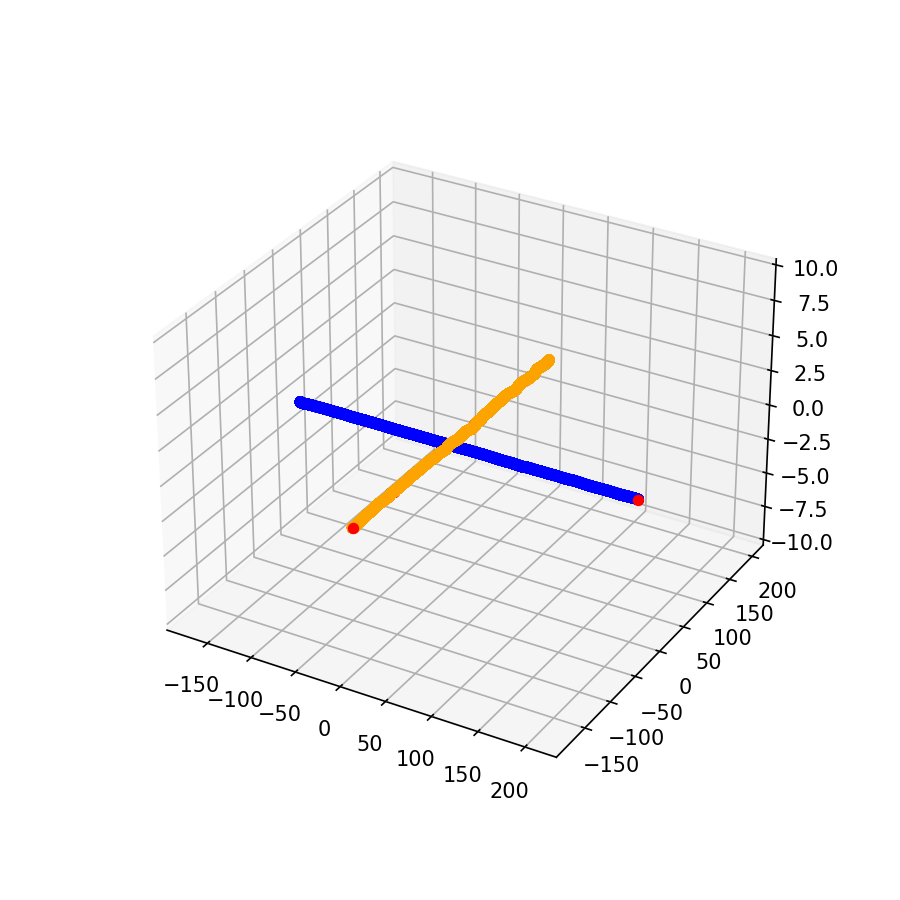

[-169.31685222    0.            0.        ]
[-94.31685222   0.           0.        ]
[-19.31685222   0.           0.        ]
[55.68314778  0.          0.        ]
[130.68314778   0.           0.        ]
[205.68314778   0.           0.        ]
[-1.08663544e-14 -1.77461035e+02  0.00000000e+00]
[-6.27392892e-15 -1.02461035e+02  0.00000000e+00]
[-1.68150342e-15 -2.74610349e+01  0.00000000e+00]
[2.91092207e-15 4.75389651e+01 0.00000000e+00]
[7.50334757e-15 1.22538965e+02 0.00000000e+00]
[1.20957731e-14 1.97538965e+02 0.00000000e+00]


In [16]:
%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(extract_from_df(AC1_GT_Trajectory, 'gt_pos', 0), 
           extract_from_df(AC1_GT_Trajectory, 'gt_pos', 1), 
           extract_from_df(AC1_GT_Trajectory, 'gt_pos', 2), c='b')

ax.scatter(extract_from_df(AC2_GT_Trajectory, 'gt_pos', 0), 
           extract_from_df(AC2_GT_Trajectory, 'gt_pos', 1), 
           extract_from_df(AC2_GT_Trajectory, 'gt_pos', 2), c='orange')

ax.scatter(AC1_Trk_Trajectory[:,2], 
           AC1_Trk_Trajectory[:,3],
           AC1_Trk_Trajectory[:,4], c='cyan', alpha=0.5)

ax.scatter(AC2_Trk_Trajectory[:,2], 
           AC2_Trk_Trajectory[:,3],
           AC2_Trk_Trajectory[:,4], c='brown', alpha=0.5)

for wpt in AC1_WPTs:
    xx, yy, zz = wpt
    ax.scatter(xx, yy, zz, c='r')
    print(wpt)

for wpt in AC2_WPTs:
    xx, yy, zz = wpt
    ax.scatter(xx, yy, zz, c='r')
    print(wpt)

    
# ax.set_xlim(-10, 510)
# ax.set_ylim(-100, 100)
ax.set_zlim(-10, 10)

plt.show()

In [17]:
AC1_State.time

73.65833333334851

In [18]:
AC2_State.time

74.10000000001477

<IPython.core.display.Javascript object>


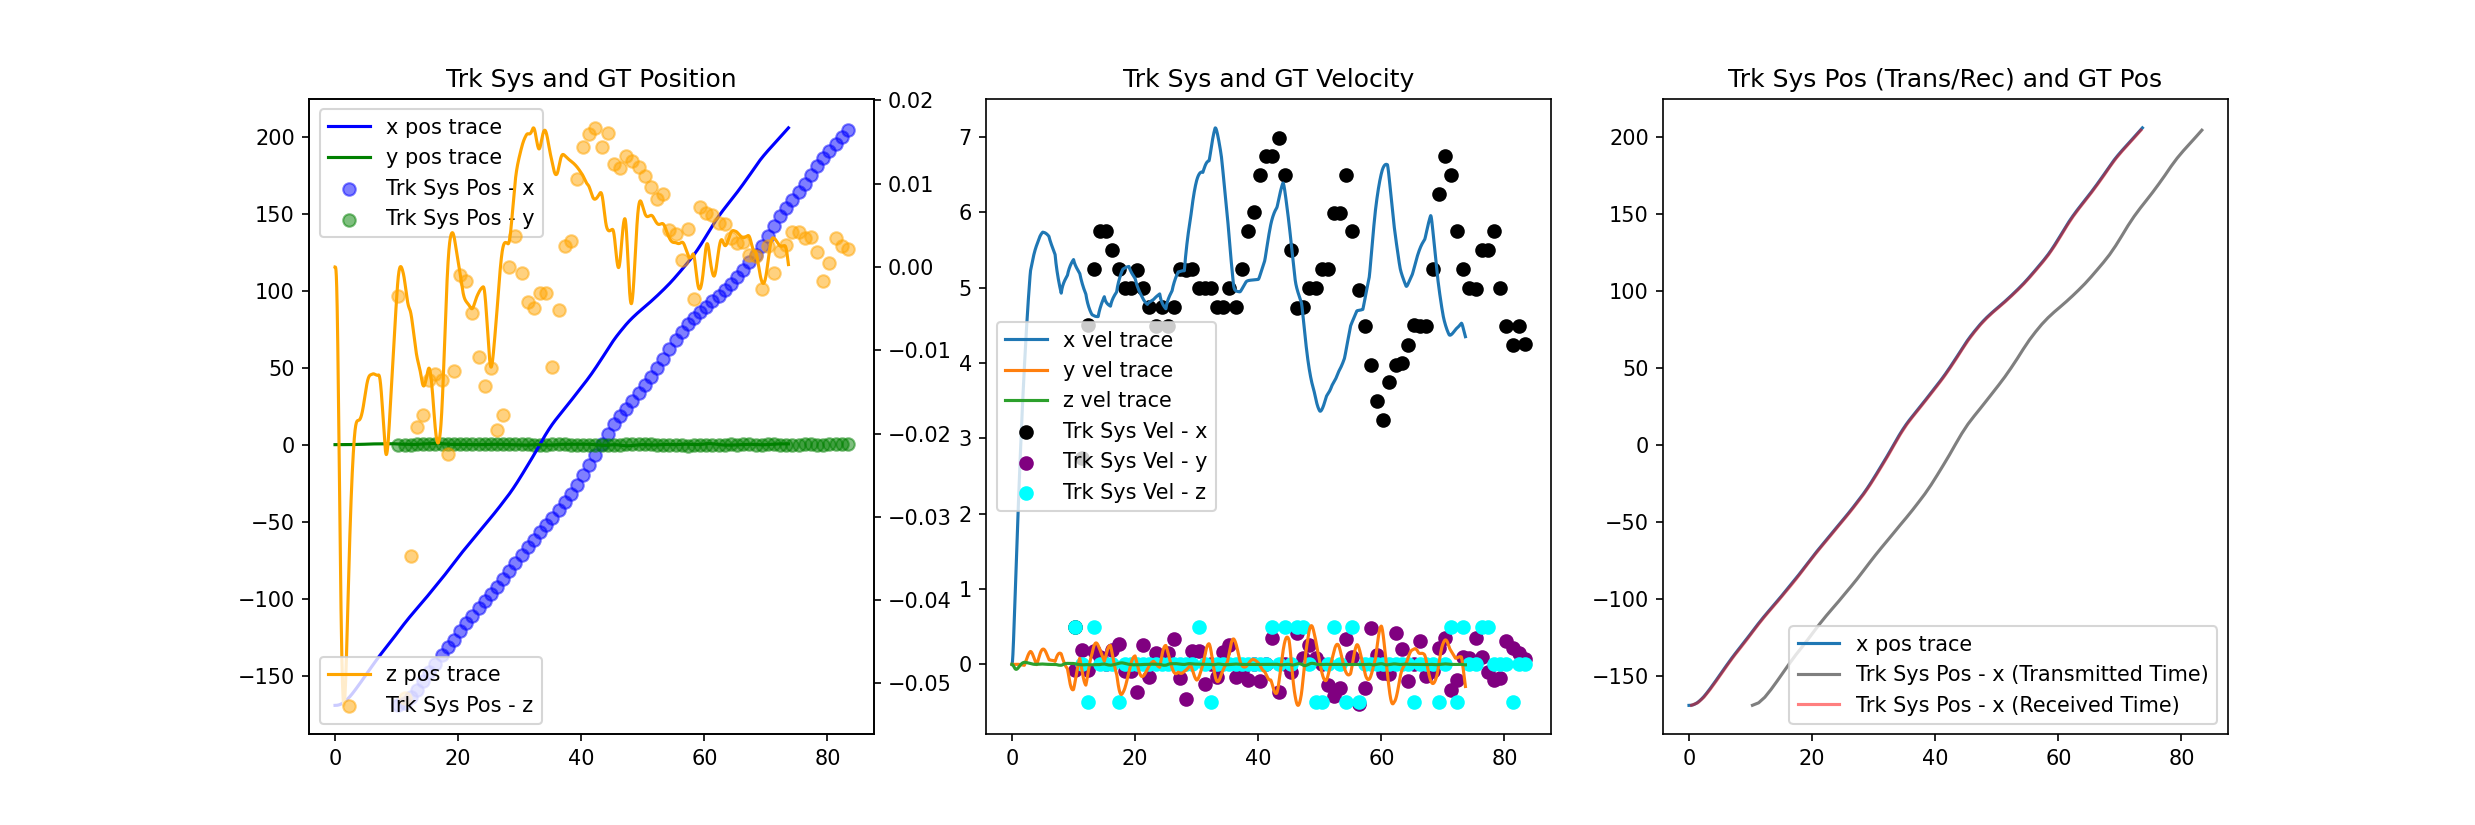

In [19]:
# AC1_Trk_Trajectory = special_concat(Trackinator.trajectories['AC1'].trajectory)
AC1_Trk_trans_time = AC1_Trk_Trajectory[:,0]
AC1_Trk_rec_time = AC1_Trk_Trajectory[:,1]
AC1_Trk_est_pos = AC1_Trk_Trajectory[:,2:5]
AC1_Trk_est_vel = AC1_Trk_Trajectory[:,5:8]

# Compare reported position and velocities (trk system) vs ground truth
fig, axs = plt.subplots(ncols=3, figsize=(16.5,5.5))

axs[0].plot(AC1_GT_Trajectory['time'], extract_from_df(AC1_GT_Trajectory, 'gt_pos', 0), label='x pos trace', c='blue')
axs[0].plot(AC1_GT_Trajectory['time'], extract_from_df(AC1_GT_Trajectory, 'gt_pos', 1), label='y pos trace', c='g')
axs[0].scatter(AC1_Trk_trans_time, AC1_Trk_est_pos[:,0], c='blue', label='Trk Sys Pos - x', alpha=0.5)
axs[0].scatter(AC1_Trk_trans_time, AC1_Trk_est_pos[:,1], c='g', label='Trk Sys Pos - y', alpha=0.5)
axs2 = axs[0].twinx()
axs2.plot(AC1_GT_Trajectory['time'], extract_from_df(AC1_GT_Trajectory, 'gt_pos', 2), label='z pos trace', c='orange')
axs2.scatter(AC1_Trk_trans_time, AC1_Trk_est_pos[:,2], c='orange', label='Trk Sys Pos - z', alpha=0.5)



axs[1].plot(AC1_GT_Trajectory['time'], extract_from_df(AC1_GT_Trajectory, 'gt_vel', 0), label='x vel trace')
axs[1].plot(AC1_GT_Trajectory['time'], extract_from_df(AC1_GT_Trajectory, 'gt_vel', 1), label='y vel trace')
axs[1].plot(AC1_GT_Trajectory['time'], extract_from_df(AC1_GT_Trajectory, 'gt_vel', 2), label='z vel trace')
axs[1].scatter(AC1_Trk_trans_time, AC1_Trk_est_vel[:,0], c='black', label='Trk Sys Vel - x')
axs[1].scatter(AC1_Trk_trans_time, AC1_Trk_est_vel[:,1], c='purple', label='Trk Sys Vel - y')
axs[1].scatter(AC1_Trk_trans_time, AC1_Trk_est_vel[:,2], c='cyan', label='Trk Sys Vel - z')



axs[2].plot(AC1_GT_Trajectory['time'], extract_from_df(AC1_GT_Trajectory, 'gt_pos', 0), label='x pos trace')
axs[2].plot(AC1_Trk_trans_time, AC1_Trk_est_pos[:,0], c='black', label='Trk Sys Pos - x (Transmitted Time)', alpha=0.5)
axs[2].plot(AC1_Trk_rec_time, AC1_Trk_est_pos[:,0], c='r', label='Trk Sys Pos - x (Received Time)', alpha=0.5)

axs[0].legend(loc='upper left')
axs2.legend(loc='lower left')
axs[0].set_title('Trk Sys and GT Position')
axs[1].legend()
axs[1].set_title('Trk Sys and GT Velocity')
axs[2].legend()
axs[2].set_title('Trk Sys Pos (Trans/Rec) and GT Pos')

plt.show()

<IPython.core.display.Javascript object>


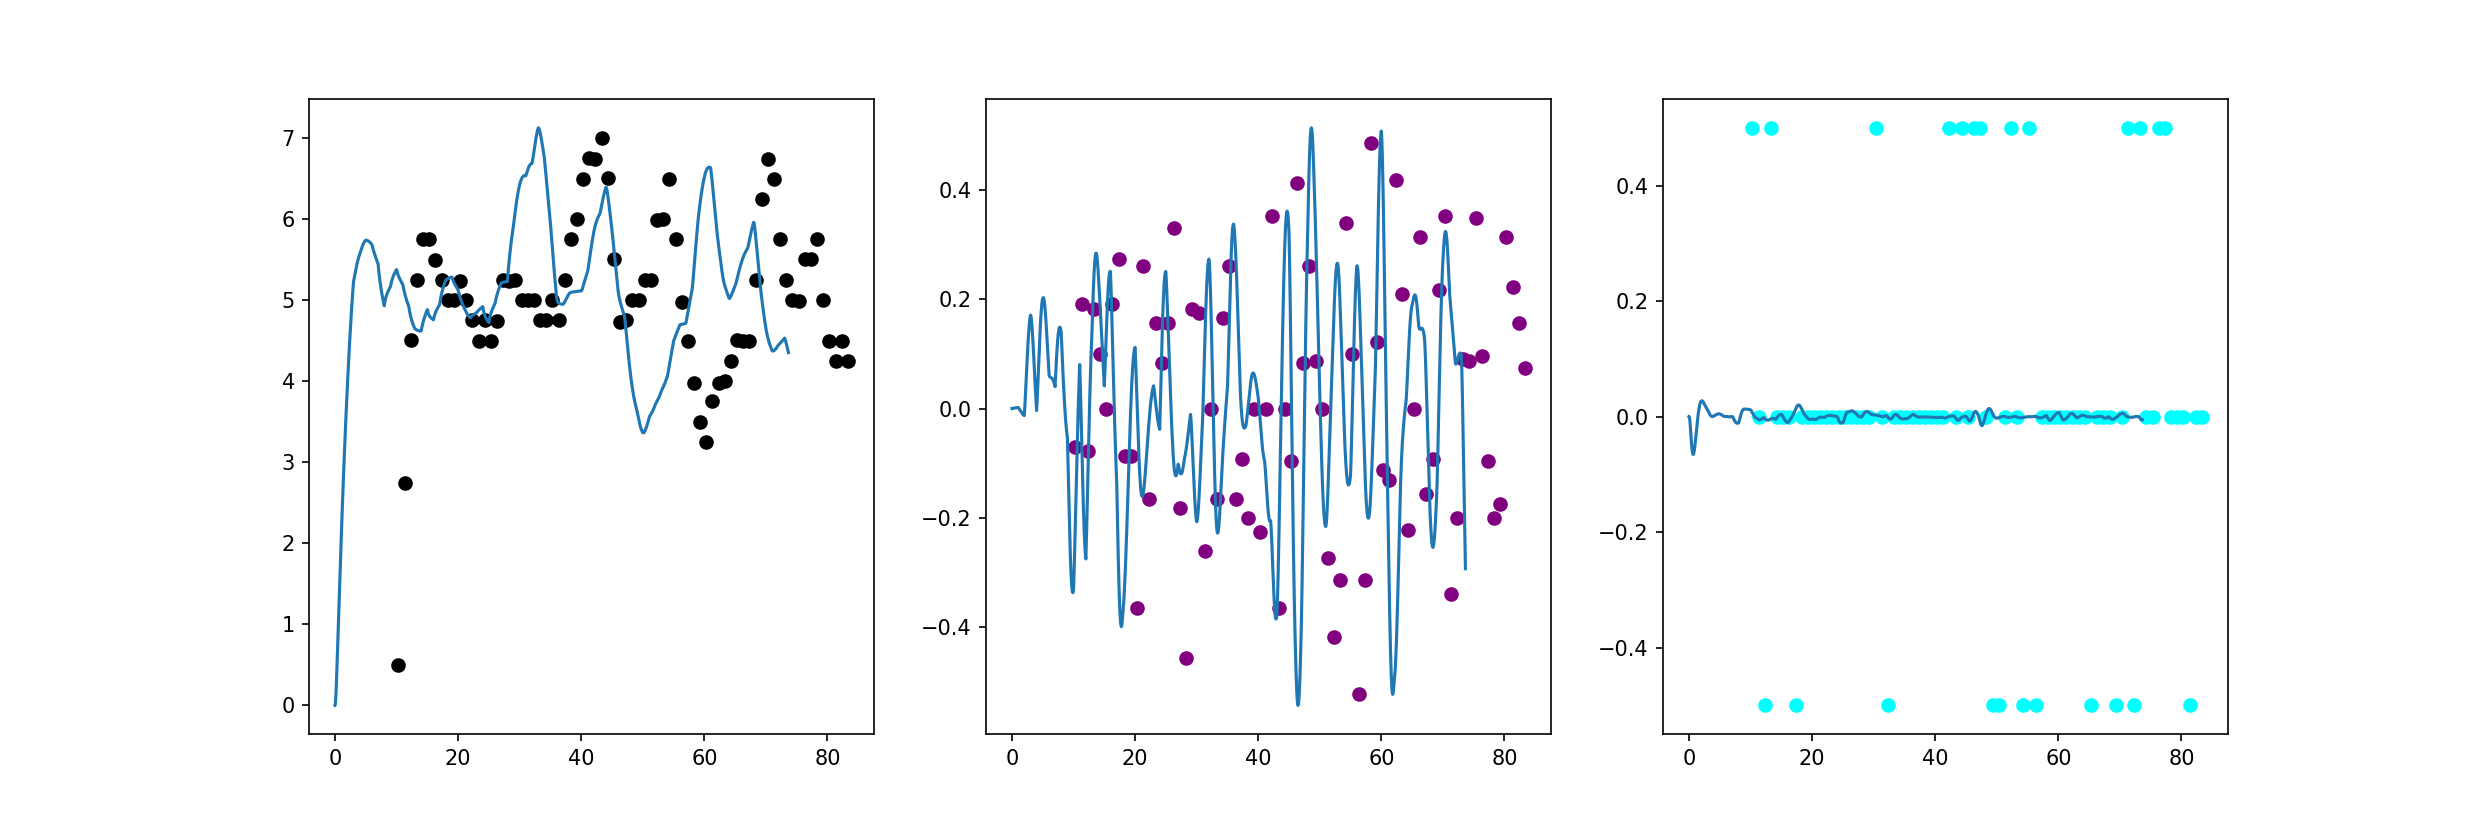

In [20]:
# Compare reported position and velocities (trk system) vs ground truth
fig, axs = plt.subplots(ncols=3, figsize=(16.5,5.5))

axs[0].plot(AC1_GT_Trajectory['time'], extract_from_df(AC1_GT_Trajectory, 'gt_vel', 0), label='x vel trace')
axs[1].plot(AC1_GT_Trajectory['time'], extract_from_df(AC1_GT_Trajectory, 'gt_vel', 1), label='y vel trace')
axs[2].plot(AC1_GT_Trajectory['time'], extract_from_df(AC1_GT_Trajectory, 'gt_vel', 2), label='z vel trace')
axs[0].scatter(AC1_Trk_trans_time, AC1_Trk_est_vel[:,0], c='black', label='Trk Sys Vel - x')
axs[1].scatter(AC1_Trk_trans_time, AC1_Trk_est_vel[:,1], c='purple', label='Trk Sys Vel - y')
axs[2].scatter(AC1_Trk_trans_time, AC1_Trk_est_vel[:,2], c='cyan', label='Trk Sys Vel - z')

plt.show()